# [DEPRECATED] scqubits example: the Explorer class
J. Koch and P. Groszkowski

For further documentation of scqubits see https://scqubits.readthedocs.io/en/latest/.

---

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np

import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep, Explorer

# The Explorer Class

Sometimes, exploring the properties of coupled quantum systems benefits from visual aides, and the possibility to see how properties change when system parameters are changed. The `Explorer` class in scqubits provides an interactive plot with multiple panels collecting an important set of information. 

The idea behind the `Explorer` class is simple: the user selects an external parameter that they wish to sweep, e.g., an external magnetic flux. The composite system is user-defined through the `HilbertSpace` and `InteractionTerm` classes, allowing flexibility to include different types and numbers of superconducting qubits and harmonic modes.

Once defined, the parameter sweep is computed by means of the `ParameterSweep` class, and spectral data is stored in memory to allow efficient, interactive display of data. The `Explorer` plots are currently fixed to:

1. Bare spectra of the individual qubits
2. Wave functions of the bare qubits
3. Dressed spectrum of the composite Hilbert space
4. Spectrum for n-photon qubit transitions, starting from a given initial state
5. AC Stark shift $\chi_{01}$ for any of the qubits
6. Charge matrix elements for any of the qubits, using the same initial state as in point 4.

## Example 1: fluxonium coupled to resonator
As a first example, we consider a system composed of a fluxonium qubit, coupled through its charge operator to the voltage inside a resonator.

### HilbertSpace setup
The initialization of the composite Hilbert space proceeds as usual; we first define the individual two subsystems that will make up the Hilbert space:

In [2]:
qbt = scq.Fluxonium(
    EJ=2.55,
    EC=0.72,
    EL=0.12,
    flux=0.0,
    cutoff=110,
    truncated_dim=9
)

osc = scq.Oscillator(
    E_osc=4.0,
    truncated_dim=5
)

We are creating two quantum systems using the `scq` library.

1. `Fluxonium`: This is a type of superconducting circuit, a quantum system that can be used as a qubit (the basic unit of quantum information). The parameters `EJ`, `EC`, `EL`, `flux`, `cutoff`, and `truncated_dim` are specific to the physics of the Fluxonium system.

2. `Oscillator`: This represents a quantum harmonic oscillator, a system that, when undisturbed, oscillates at some steady frequency. `E_osc` is the energy of the oscillator and `truncated_dim` is the dimension after truncation.

Here's a brief explanation of the parameters:

- `EJ`, `EC`, `EL`: Energy scales for the Fluxonium system (Josephson, charging, and inductive energy respectively).
- `flux`: External magnetic flux applied to the Fluxonium circuit.
- `cutoff`: The maximum number of charge states included in the Hilbert space.
- `truncated_dim`: The dimension of the Hilbert space after it has been truncated.
- `E_osc`: Energy of the quantum harmonic oscillator.

In [3]:
hilbertspace = scq.HilbertSpace([qbt, osc])

The interaction between fluxonium and resonator is of the form $H_\text{int} = g n (a+a^\dagger)$, where $n$ is the fluxonium's charge operator: `qbt.n_operator()`. This structure is captured by creating an `InteractionTerm` object. Since this is the only interaction term, the `interaction_list` contains only this one term. It is inserted into the `HilbertSpace` object.

In [4]:
# Define the interaction term
interaction_term = InteractionTerm(
    g_strength=0.2,
    operator_list=[(0, qbt.n_operator()), (1, osc.creation_operator() + osc.annihilation_operator())]
)

# Define the subsystem list
subsystem_list = [qbt, osc]

# Get the Hamiltonian
hamiltonian = interaction_term.hamiltonian(subsystem_list)

# Print the Hamiltonian
print(hamiltonian)

Quantum object: dims = [[9, 5], [9, 5]], shape = (45, 45), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]


### Parameter sweep setup
We consider sweeping the external flux through the fluxonium loop. To create the necessary `ParameterSweep` object, we specify:
1. `param_name`: the name of the sweep parameter (below expressed in LaTeX format as the flux in units of the flux quantum)
2. `param_vals`: an array with the flux values used in the sweep
3. `subsys_update_list`: a list containing all Hilbert space subsystems that change as the flux is varied
4. `update_hilbertspace(param_val)`: a function that shows how a change in the sweep parameter affects the Hilbert space; here only the `.flux` attributed of the fluxonium qubit needs to be changed

These ingredients all make it into the initialization of the `ParameterSweep` object. Once initialized, spectral data is generated and stored. Here, we additionally generate data for dispersive shifts and charge matrix elements.

In [5]:
#! pip install pathos

In [6]:
param_name = r'$\Phi_{ext}/\Phi_0$'
param_vals = np.linspace(-0.5, 0.5, 100)

subsys_update_list = [qbt]

def update_hilbertspace(param_val):
    qbt.flux = param_val

sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name={param_name: param_vals},
    update_hilbertspace=update_hilbertspace,
    evals_count=10,
    subsys_update_info={'qbt': subsys_update_list},
    num_cpus=4
)

Parallel compute bare eigensys for subsystem Fluxonium_1 [num_cpus=4]

Parallel compute bare eigensys for subsystem Oscillator_1 [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

### Starting the Explorer class
At this point, everything is prepared to start the interactive `Explorer` and play with the interactive display!

In [7]:
# Create an Explorer object
explorer = Explorer(sweep=sweep, ncols=3)


Container(children=[Sheet(children=[Card(children=[Img(layout=None, src='data:image/png;base64,iVBORw0KGgoAAAA…

In [8]:
# Access the ParameterSweep object
sweep = explorer.sweep
sweep

In [9]:
# Access the subsystems
subsystems = explorer.subsystems
subsystems

[Fluxonium(**{'EJ': 2.55, 'EC': 0.72, 'EL': 0.12, 'flux': -0.5, 'cutoff': 110, 'truncated_dim': 9, 'id_str': 'Fluxonium_1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None}),
 Oscillator(**{'E_osc': 4.0, 'l_osc': None, 'truncated_dim': 5, 'id_str': 'Oscillator_1'})]

In [10]:
# Access the subsystem names
subsys_names = explorer.subsys_names
subsys_names

['Fluxonium_1', 'Oscillator_1']

{'panel_switch_by_plot_id': {PlotID(PlotType.ENERGY_SPECTRUM, [Fluxonium(**{'EJ': 2.55, 'EC': 0.72, 'EL': 0.12, 'flux': -0.5, 'cutoff': 110, 'truncated_dim': 9, 'id_str': 'Fluxonium_1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})]): LinkedSwitch(dense=True, label='Energy spectrum', layout=None, v_model=True),
  PlotID(PlotType.WAVEFUNCTIONS, [Fluxonium(**{'EJ': 2.55, 'EC': 0.72, 'EL': 0.12, 'flux': -0.5, 'cutoff': 110, 'truncated_dim': 9, 'id_str': 'Fluxonium_1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})]): LinkedSwitch(dense=True, label='Wavefunctions', layout=None, v_model=True),
  PlotID(PlotType.MATRIX_ELEMENTS, [Fluxonium(**{'EJ': 2.55, 'EC': 0.72, 'EL': 0.12, 'flux': -0.5, 'cutoff': 110, 'truncated_dim': 9, 'id_str': 'Fluxonium_1', 'evals_method': None, 'evals_method_options': None, 'esys_method': None, 'esys_method_options': None})]): LinkedSwitch(dense=True, l
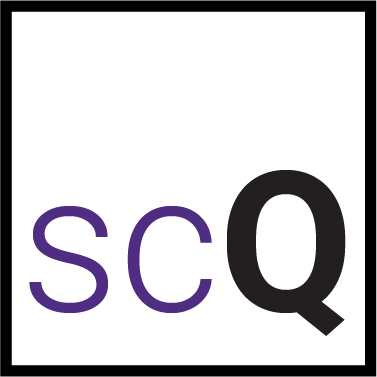

In [11]:
# Access the UI elements
ui = explorer.ui
ui

In [12]:
# Access the settings
settings = explorer.settings
settings

## Example 2:  two transmons coupled to a resonator
In the following second example, we consider a system composed of two flux-tunable transmons, capacitively coupled to one joint harmonic mode. (The flux is assumed to arise from a global field, and the SQUID-loop areas of the two transmons are different with an area ratio of 1.4) 

### Hilbert space setup

In [13]:
qbt1 = scq.Transmon(
     EJ=25.0,
     EC=0.2,
     ng=0,
     ncut=30,
     truncated_dim=3)

qbt2 = scq.Transmon(
     EJ=15.0,
     EC=0.15,
     ng=0,
     ncut=30,
     truncated_dim=3)

resonator = scq.Oscillator(
    E_osc=5.5,
    truncated_dim=4)

hilbertspace = HilbertSpace([qbt1, qbt2, resonator])

g1 = 0.1  # coupling resonator-CPB1 (without charge matrix elements)
g2 = 0.2  # coupling resonator-CPB2 (without charge matrix elements)

interaction1 = InteractionTerm(
    g_strength=g1,
    operator_list=[(0, qbt1.n_operator()), (2, resonator.creation_operator() + resonator.annihilation_operator())],
    add_hc=False
)

interaction2 = InteractionTerm(
    g_strength=g2,
    operator_list=[(1, qbt2.n_operator()), (2, resonator.creation_operator() + resonator.annihilation_operator())],
    add_hc=False
)

interaction_list = [interaction1, interaction2]
hilbertspace.interaction_list = interaction_list

# Print the interaction terms
for i, interaction in enumerate(interaction_list, 1):
    print(f"Interaction {i}:")
    print(interaction)

Interaction 1:
InteractionTerm----------|
                         | g_strength: 0.1
                         | operator_list: [(0, array([[-30,   0,   0, ...,   0,   0,   0],
  ...
                         | add_hc: False

Interaction 2:
InteractionTerm----------|
                         | g_strength: 0.2
                         | operator_list: [(1, array([[-30,   0,   0, ...,   0,   0,   0],
  ...
                         | add_hc: False



### Parameter sweep setup

In [14]:
param_name = r'$\Phi_{ext}/\Phi_0$'
param_vals = np.linspace(0.0, 1.0, 150)

subsys_update_list = [qbt1, qbt2]


def update_hilbertspace(param_val):     # function that shows how Hilbert space components are updated
    qbt1.EJ = 30*np.abs(np.cos(np.pi * param_val))
    qbt2.EJ = 40*np.abs(np.cos(np.pi * param_val * 2))
    

sweep = ParameterSweep(
    hilbertspace=hilbertspace,
    paramvals_by_name={param_name: param_vals},
    update_hilbertspace=update_hilbertspace,
    evals_count=10,
    subsys_update_info={'qbt': subsys_update_list},
    num_cpus=4
)

For that reason, it is recommended to use coupling operators specified as callable functions.

 C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\scqubits\core\param_sweep.py: 971

Parallel compute bare eigensys for subsystem Transmon_1 [num_cpus=4]

Parallel compute bare eigensys for subsystem Transmon_2 [num_cpus=4]

Parallel compute bare eigensys for subsystem Oscillator_3 [num_cpus=4]

Parallel compute dressed eigensys [num_cpus=4]

### Start Explorer

In [15]:
# Create an Explorer object
explorer = Explorer(sweep=sweep, ncols=3)

Container(children=[Sheet(children=[Card(children=[Img(layout=None, src='data:image/png;base64,iVBORw0KGgoAAAA…